In [ ]:
%matplotlib widget

import polars as pl
import numpy as np

import k3d
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact

from pyergonomics import ProjectSettings, add_pose_assessment_columns

In [2]:
#
# 1. load data
#
# this file is capturing me using the optitrack of humlab at Umea.
# one person, clean and nice data
#

settings = ProjectSettings("../data/optitrack")
tracker = settings.tracker
skeleton = settings.pose_skeleton

print(settings)

Project Settings from ../data/optitrack/project.toml:
  - Number of frames: 7297
  - FPS: 120.00480019200768
  - Pose skeleton: optitrack
  - Tracking file: ../data/optitrack/tracking.parquet


In [3]:
#
# visualize skeleton
#

def set_frame(n):
    joints = tracker.get_keypoints_for_person(person_id, frame=n)[0]
    joints_plot.positions = joints
    lines_plot.vertices = joints

person_id = tracker.get_person_ids()[0]

plot = k3d.plot(grid=(-2, -2, 0, 2, 2, 2), camera_mode='orbit')

joints_plot = k3d.points([], point_size=0.03, shader='flat', color=0xff0000) 
lines_plot = k3d.lines([], list(skeleton.bones), width=0.005, color=0xff0000, indices_type="segment")

plot += joints_plot
plot += lines_plot
plot.display()

interact(set_frame, n=widgets.IntSlider(min=0, max=settings.number_of_frames-1, step=1, value=10, layout=widgets.Layout(width='100%')))

Output()

interactive(children=(IntSlider(value=10, description='n', layout=Layout(width='100%'), max=7296), Output()), …

<function __main__.set_frame(n)>

In [4]:
#
# make assessment
#

if tracker.has_pose_assessment:
    tracker.remove_pose_assessment_columns()

add_pose_assessment_columns(tracker, skeleton)

In [ ]:
#
# plot pose assesment (interactive)
#

plt.ion()

person_id = tracker.get_person_ids()[0]
metrics = tracker.get_pose_metrics_for_person(person_id)
time_axis = np.arange(settings.number_of_frames) / settings.frames_per_second

plt.figure(figsize=(10, 5))

plt.plot(time_axis, metrics["trunk_bending"], label="Bending")
plt.plot(time_axis, metrics["trunk_side_bending"], label="Side Bending")
plt.plot(time_axis, metrics["trunk_twist"], label="Twist")

plt.axhline(y=60, color='#ff9999', linestyle='--', alpha=0.5, label="Threshold (60°)")
plt.axhline(y=20, color='#ffcc99', linestyle='--', alpha=0.5, label="Threshold (20°)")

plt.xlabel("Time (seconds)")
plt.ylabel("Angle (degrees)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [6]:
#
# static posture detection (EAWS: >= 4 seconds)
#

def find_static_poses(df: pl.DataFrame, column: str, min_val: float, max_val: float,
                      min_duration_frames: int) -> pl.DataFrame:
    """Find periods where column is in [min_val, max_val) for >= min_duration_frames."""
    return (
        df
        .with_columns([
            ((pl.col(column) >= min_val) & (pl.col(column) < max_val)).alias("in_range"),
        ])
        .with_columns([
            pl.col("in_range").rle_id().alias("run_id")
        ])
        .filter(pl.col("in_range"))
        .group_by("run_id")
        .agg([
            pl.col("frame").first().alias("start_frame"),
            pl.col("frame").last().alias("end_frame"),
            pl.len().alias("duration_frames"),
        ])
        .filter(pl.col("duration_frames") >= min_duration_frames)
        .sort("start_frame")
    )

# Find static poses for person
fps = settings.frames_per_second
min_frames = int(4 * fps)  # 4 seconds

person_df = tracker.df.filter(pl.col("person") == person_id)

moderate_poses = find_static_poses(person_df, "trunk_bending", 20, 60, min_frames)
severe_poses = find_static_poses(person_df, "trunk_bending", 60, float('inf'), min_frames)

print(f"Moderate bending (20-60°) static poses >= 4s: {len(moderate_poses)}")
print(f"Severe bending (>60°) static poses >= 4s: {len(severe_poses)}")

Moderate bending (20-60°) static poses >= 4s: 0
Severe bending (>60°) static poses >= 4s: 1


In [ ]:
#
# plot trunk bending with static posture highlighting (static)
#

plt.ioff()

fig, ax = plt.subplots(figsize=(12, 5))

# Plot colored background for static postures (moderate = yellow, severe = red)
for row in moderate_poses.iter_rows(named=True):
    start_t = row["start_frame"] / fps
    end_t = row["end_frame"] / fps
    ax.axvspan(start_t, end_t, color='#ffcc00', alpha=0.3, label='_')

for row in severe_poses.iter_rows(named=True):
    start_t = row["start_frame"] / fps
    end_t = row["end_frame"] / fps
    ax.axvspan(start_t, end_t, color='#ff4444', alpha=0.3, label='_')

# Plot the bending curve
ax.plot(time_axis, metrics["trunk_bending"], color='#333333', linewidth=1, label="Trunk Bending")

# Threshold lines
ax.axhline(y=60, color='#ff4444', linestyle='--', alpha=0.7, linewidth=1)
ax.axhline(y=20, color='#ffcc00', linestyle='--', alpha=0.7, linewidth=1)

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color='#333333', linewidth=1, label='Trunk Bending'),
    Patch(facecolor='#ffcc00', alpha=0.3, label=f'Static 20-60° (≥4s): {len(moderate_poses)}'),
    Patch(facecolor='#ff4444', alpha=0.3, label=f'Static >60° (≥4s): {len(severe_poses)}'),
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angle (degrees)")
ax.set_title("Trunk Bending with Static Posture Detection (EAWS ≥4s)")
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

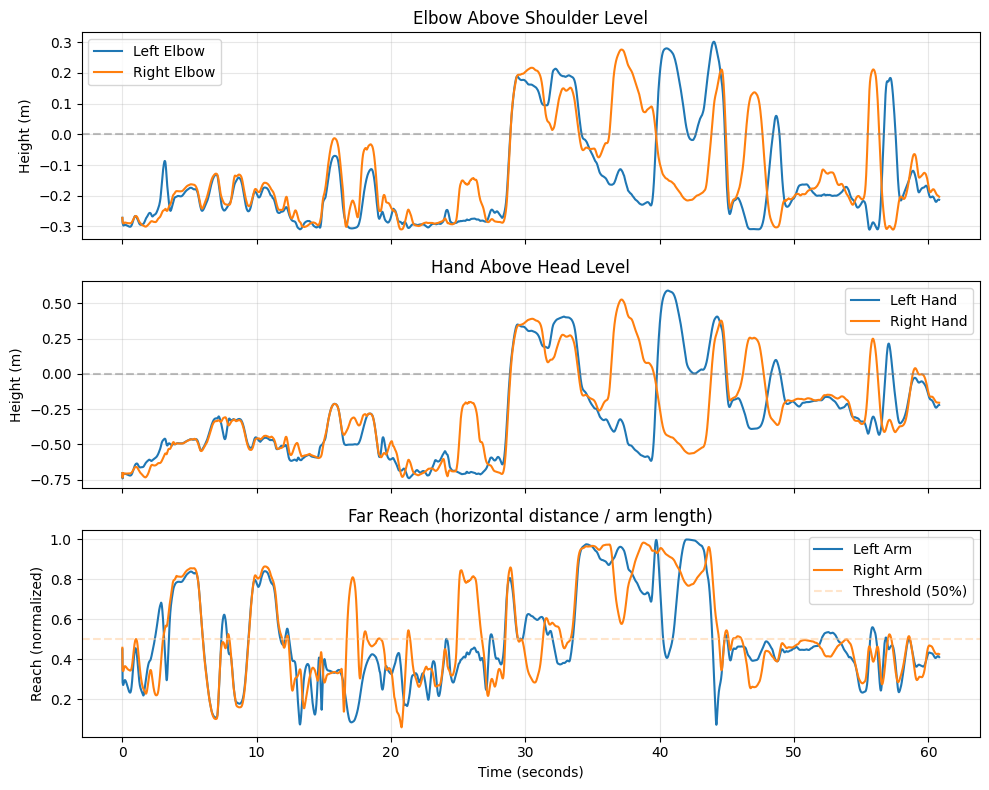

In [8]:
#
# plot arm assessment
#

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Elbow above shoulder
axes[0].plot(time_axis, metrics["left_elbow_above_shoulder"], label="Left Elbow")
axes[0].plot(time_axis, metrics["right_elbow_above_shoulder"], label="Right Elbow")
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel("Height (m)")
axes[0].set_title("Elbow Above Shoulder Level")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hand above head
axes[1].plot(time_axis, metrics["left_hand_above_head_level"], label="Left Hand")
axes[1].plot(time_axis, metrics["right_hand_above_head_level"], label="Right Hand")
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel("Height (m)")
axes[1].set_title("Hand Above Head Level")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Far reach
axes[2].plot(time_axis, metrics["left_far_reach"], label="Left Arm")
axes[2].plot(time_axis, metrics["right_far_reach"], label="Right Arm")
axes[2].axhline(y=0.5, color='#ffcc99', linestyle='--', alpha=0.5, label="Threshold (50%)")
axes[2].set_ylabel("Reach (normalized)")
axes[2].set_xlabel("Time (seconds)")
axes[2].set_title("Far Reach (horizontal distance / arm length)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

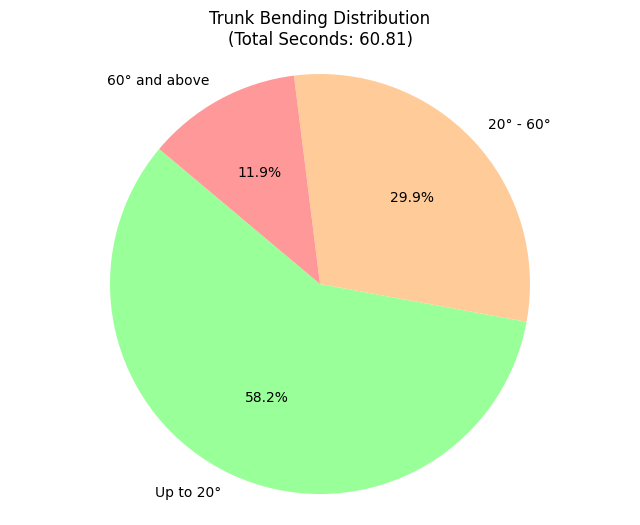

In [9]:
#
# plot aggregated data
#

bending_data = metrics["trunk_bending"]

count_low = np.sum(bending_data <= 20)    
count_medium = np.sum((bending_data > 20) & (bending_data < 60))
count_high = np.sum(bending_data >= 60)

# 3. Plot Pie Chart
sizes = [count_low, count_medium, count_high]
labels = ['Up to 20°', '20° - 60°', '60° and above']
colors = ['#99ff99', '#ffcc99', '#ff9999']  # Green, Orange, Red

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title(f"Trunk Bending Distribution\n(Total Seconds: {len(bending_data)/settings.frames_per_second:.2f})")
plt.axis('equal')
plt.show()

In [ ]:
#
# combine 3D with 3D
#


